### Javier Alemán Rodríguez

# Predicción de riesgo de derrumbamiento - Terremotos

## Extracción y visualizado de datos

### Instalación e importación de librerías

In [2]:
%pip install lazypredict

Note: you may need to restart the kernel to use updated packages.Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   --- ------------------------------------ 0.1/1.3 MB 3.3 MB/s eta 0:00:01
   --------- ------------------------------ 0.3/1.3 MB 4.1 MB/s eta 0:00:01
   ---------------------- ----------------- 0.8/1.3 MB 6.9 MB/s eta 0:00:01
   ---------------------------------------  1.3/1.3 MB 9.4 MB/s eta 0:00:01
   ---------------------------------------- 1.3/1.3 MB 7.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 1.1/99.8 MB 34.6 MB/s eta 0:00:03
    --------------------------------------- 2.3/99.8 MB 28.9 MB/s eta 0:00:04
   - -------------------------------------- 3.5/99.8 MB 31.7 MB/s eta 0:00:04
   - -------------------------------------- 4.8/99.8 MB 30.2 MB/s eta 0:00:04
   -- --------------------

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [3]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics
from scipy import cluster
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, RandomizedSearchCV
import lightgbm as lgb
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

### Importación de los datos

In [4]:
url = 'https://raw.githubusercontent.com/JaviARo/Datasets/main/Earthquake_damage'

train_labels = pd.read_csv(f'{url}/train_labels.csv')
train_values = pd.read_csv(f'{url}/train_values.csv')
test_values = pd.read_csv(f'{url}/test_values.csv')

### Visualización de datos

In [5]:
train_labels_shape = train_labels.shape
print(f"Filas: {train_labels_shape[0]}\nColumnas: {train_labels_shape[1]}")
train_labels.head()

Filas: 260601
Columnas: 2


,building_id,damage_grade
0,802906,3
1,28830,2
2,94947,3
3,590882,2
4,201944,3


In [4]:
train_values_shape = train_values.shape
print(f"Filas: {train_values_shape[0]}\nColumnas: {train_values_shape[1]}")
train_values.head()

Filas: 260601
Columnas: 39


,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,802906,6,487,12198,2,30,6,5,t,r,...,0,0,0,0,0,0,0,0,0,0
1,28830,8,900,2812,2,10,8,7,o,r,...,0,0,0,0,0,0,0,0,0,0
2,94947,21,363,8973,2,10,5,5,t,r,...,0,0,0,0,0,0,0,0,0,0
3,590882,22,418,10694,2,10,6,5,t,r,...,0,0,0,0,0,0,0,0,0,0
4,201944,11,131,1488,3,30,8,9,t,r,...,0,0,0,0,0,0,0,0,0,0


In [5]:
test_values_shape = test_values.shape
print(f"Filas: {test_values_shape[0]}\nColumnas: {test_values_shape[1]}")
test_values.head()

Filas: 86868
Columnas: 39


,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,300051,17,596,11307,3,20,7,6,t,r,...,0,0,0,0,0,0,0,0,0,0
1,99355,6,141,11987,2,25,13,5,t,r,...,1,0,0,0,0,0,0,0,0,0
2,890251,22,19,10044,2,5,4,5,t,r,...,0,0,0,0,0,0,0,0,0,0
3,745817,26,39,633,1,0,19,3,t,r,...,0,0,1,0,0,0,0,0,0,0
4,421793,17,289,7970,3,15,8,7,t,r,...,0,0,0,0,0,0,0,0,0,0


## Normalización y limpieza de datos

In [6]:
def RemoveColumns(df, drop_cols):
  if len(drop_cols) > 0:
  	df = df.drop(columns=[drop_cols], axis=1)
  return df

def CategoricalToNumerical(df, categ_cols):
	for col in categ_cols:
		categories = set(df[col])
		categories = list(categories)
		indexes = list(map(lambda tupl: tupl[0], enumerate(categories)))
		df[col].replace(categories, indexes, inplace=True)
	return df

def NumericalDataScalerAndFillNaN(df):
  # Selección de columnas numéricas
  numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.to_list()

  preprocessor_RR = ColumnTransformer(
                    [('scale', MinMaxScaler(), numeric_cols)],remainder='passthrough')

  df[numeric_cols] = preprocessor_RR.fit_transform(df[numeric_cols])
  df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())
  return df

def TransformVars(df, drop_cols = [], categ_cols = []):
  df = RemoveColumns(df, drop_cols)
  df = CategoricalToNumerical(df, categ_cols)
  df = NumericalDataScalerAndFillNaN(df)
  return df

In [8]:
earthquake_categ_cols = [
  'land_surface_condition', 
  'foundation_type',
  'roof_type',
  'ground_floor_type',
  'other_floor_type',
  'position',
  'plan_configuration',
  'legal_ownership_status'
]

train_transformed = TransformVars(train_values, categ_cols = earthquake_categ_cols)

train_completed = train_values.copy()
train_completed['damage_grade'] = train_labels['damage_grade']
train_stratified = train_completed.groupby('damage_grade', group_keys=False).apply(lambda x: x.sample(frac=0.1))

X = train_stratified.drop(columns=['damage_grade'], axis=1)
y = train_stratified['damage_grade']

In [9]:
print(X.shape)
X.head()

(26060, 39)


,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
208182,0.22,0.87,0.85,0.96,0.25,0.03,0.02,0.13,0.50,0.50,...,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
259534,0.48,0.67,0.51,0.50,0.12,0.01,0.07,0.17,0.50,0.50,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
161054,0.20,0.87,0.43,0.92,0.12,0.00,0.05,0.10,0.50,1.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
63969,0.19,0.87,0.74,0.68,0.00,0.00,0.13,0.00,0.50,0.50,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
199848,0.50,0.87,0.16,0.96,0.12,0.02,0.04,0.10,0.50,0.50,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


### Separación de variables de entrenamiento, validación y test

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=1)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

## Selección de características

### Matriz de correlación

In [67]:
def PlotMatrizCorrelacion(corr_mat_data):
	sns.set_theme()
	data_mask = np.triu(np.ones_like(corr_mat_data, dtype = bool)) # Recorta la gráfica

	cmap = sns.diverging_palette(100, 7, s = 75, l = 40, n = 5, center = 'light', as_cmap = True)

	plt.figure(figsize = (23, 15))
	# sns.heatmap(X.corr(), square=True, annot=True)
	sns.heatmap(corr_mat_data, annot = True, cmap = cmap, fmt = '.2f', center = 0,
							annot_kws = {'size': 12}, mask = data_mask).set_title('Correlations Among Features (in Competition Dataset)')

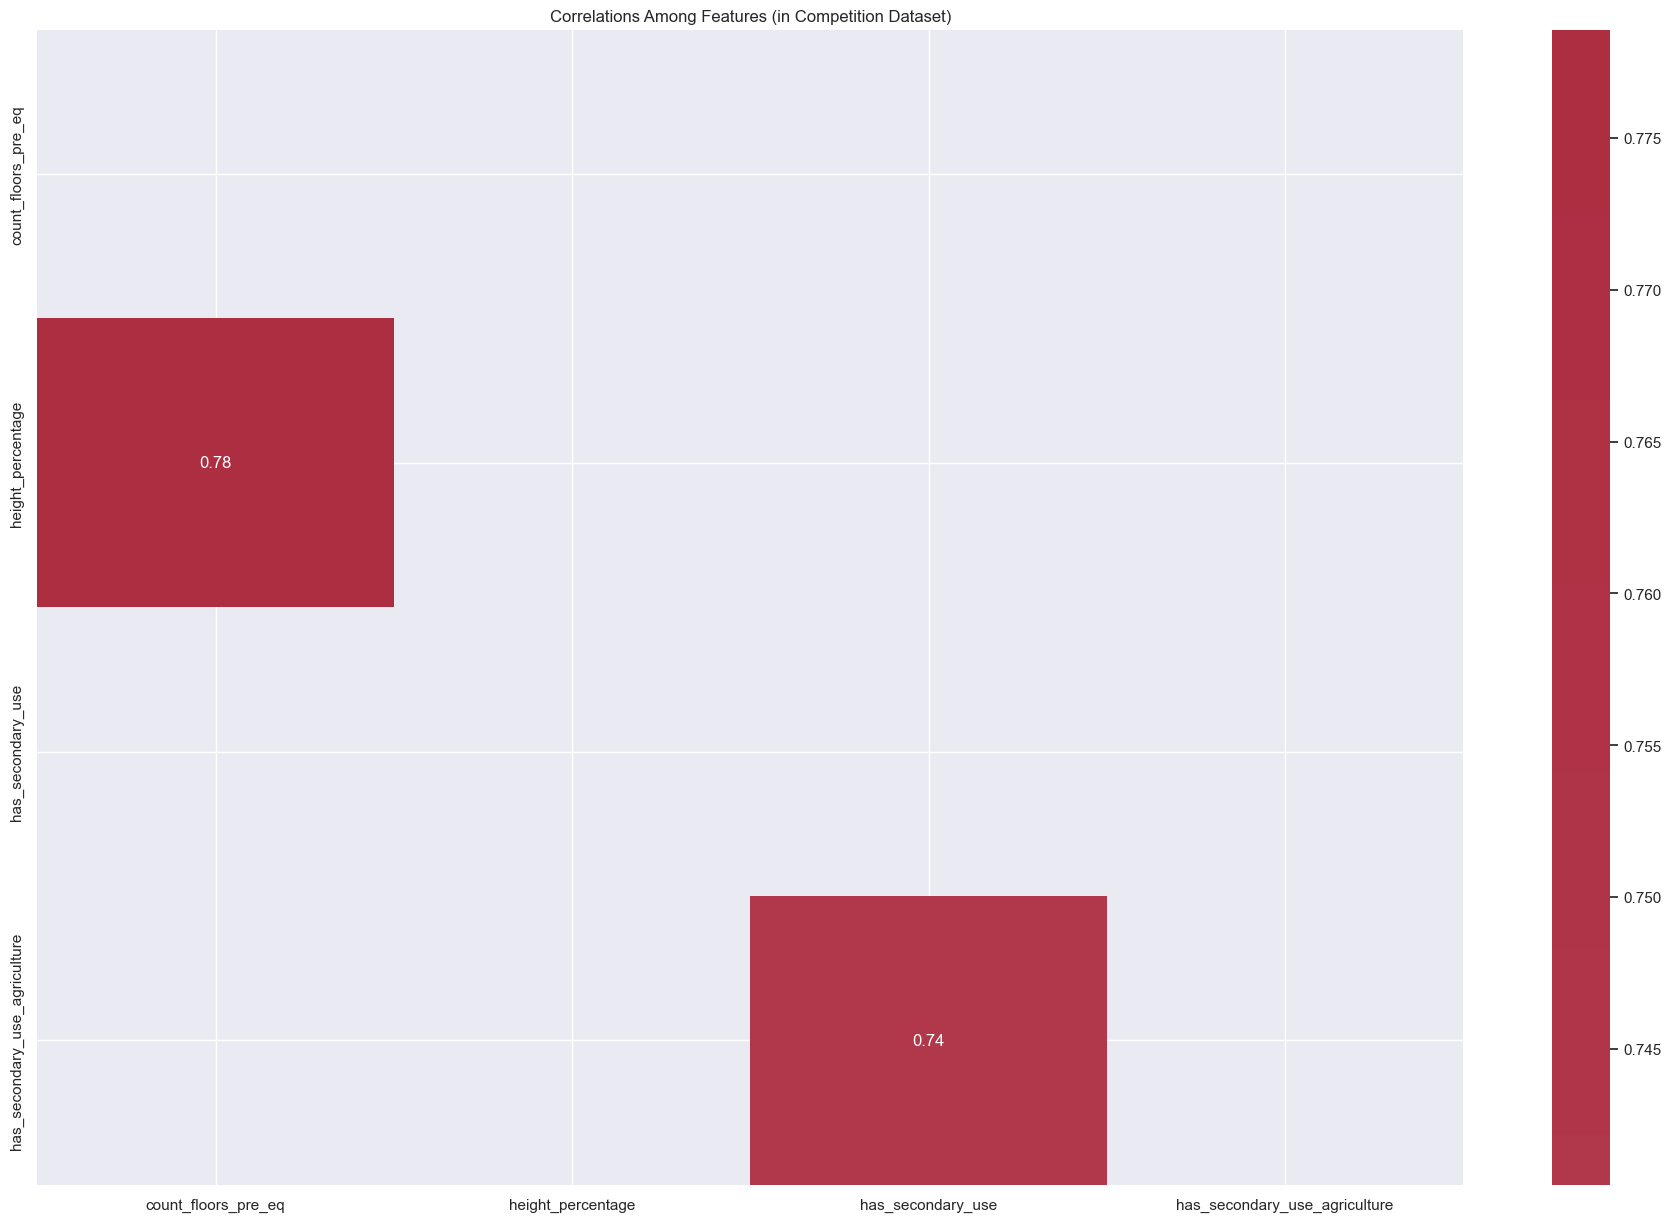

In [68]:
correlation_matrix = X.corr()

# Correlaciones mayores a 0.7
threshold = 0.7
high_correlations = correlation_matrix[(correlation_matrix > threshold) & (correlation_matrix < 1.0)]

high_correlations.dropna(axis=0, how='all', inplace=True)  # Elimina las filas que no tienen datos
high_correlations.dropna(axis=1, how='all', inplace=True)  # Elimina las columnas que no tienen datos

PlotMatrizCorrelacion(high_correlations)

### Dendograma

In [70]:
def Dendogram(X, threshold, title):
	X_T = X.T

	dist = sklearn.metrics.DistanceMetric.get_metric('euclidean')
	D = dist.pairwise(X_T)
	avD = np.average(D)
	print("Distancia Media\t {:6.2f}".format(avD))

	plt.figure(figsize=(12, 6))
	plt.title(title)
	plt.xlabel('Columnas')
	plt.ylabel('Distancia')

	clusters = cluster.hierarchy.linkage(D, method='complete')
	cluster.hierarchy.dendrogram(clusters, color_threshold=threshold, labels=X.columns.to_list(), leaf_rotation=90)
	plt.show()

Distancia Media	  56.72


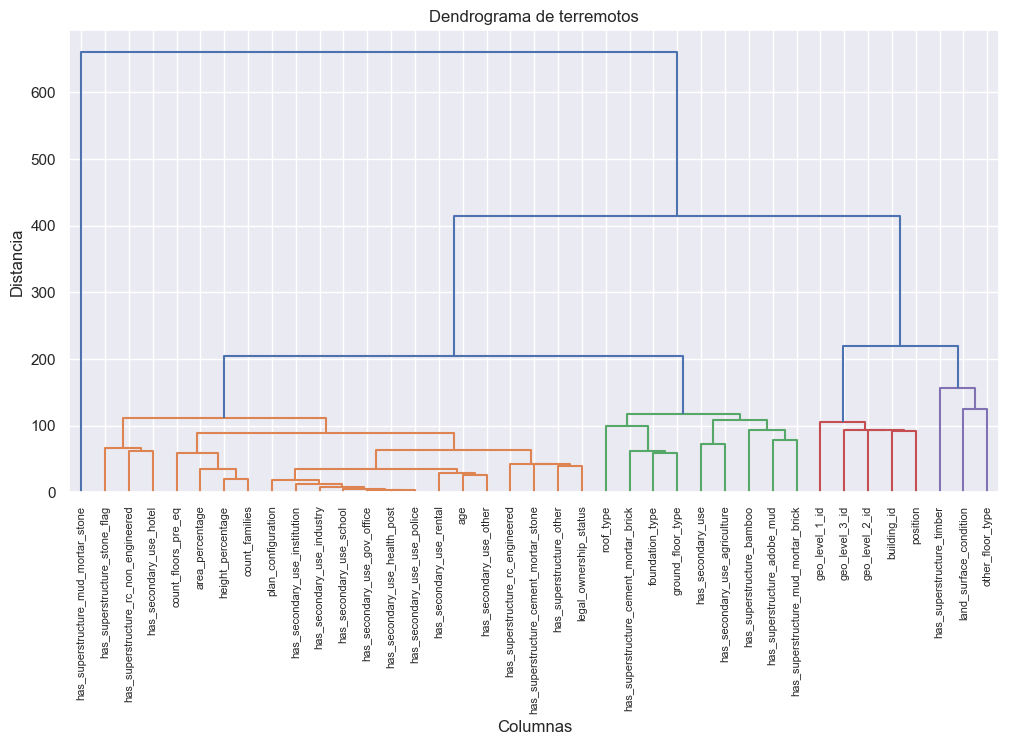

In [73]:
Dendogram(X, 180, 'Dendrograma de terremotos')

### SelectKBest

In [74]:
def ApplySelectKBest(X_train, X_val, y_train, k):
	selector = SelectKBest(f_regression, k=k)

	selector.fit_transform(X_train, y_train)
	selector.transform(X_val)

	print(f"Mejores {k} columnas = [")
	for col in selector.get_feature_names_out():
		print(f"  \'{col}\'")
	print("]\n")

In [80]:
ApplySelectKBest(X_train, X_val, y_train, 1)
ApplySelectKBest(X_train, X_val, y_train, 3)
ApplySelectKBest(X_train, X_val, y_train, 5)
ApplySelectKBest(X_train, X_val, y_train, 6)

Mejores 1 columnas = [
  'ground_floor_type'
]

Mejores 3 columnas = [
  'foundation_type'
  'ground_floor_type'
  'has_superstructure_mud_mortar_stone'
]

Mejores 5 columnas = [
  'foundation_type'
  'ground_floor_type'
  'other_floor_type'
  'has_superstructure_mud_mortar_stone'
  'has_superstructure_cement_mortar_brick'
]

Mejores 6 columnas = [
  'foundation_type'
  'ground_floor_type'
  'other_floor_type'
  'has_superstructure_mud_mortar_stone'
  'has_superstructure_cement_mortar_brick'
  'has_superstructure_rc_engineered'
]



In [85]:
ApplySelectKBest(X_train, X_val, y_train, 14)

Mejores 14 columnas = [
  'geo_level_1_id'
  'count_floors_pre_eq'
  'area_percentage'
  'foundation_type'
  'roof_type'
  'ground_floor_type'
  'other_floor_type'
  'has_superstructure_mud_mortar_stone'
  'has_superstructure_cement_mortar_brick'
  'has_superstructure_rc_non_engineered'
  'has_superstructure_rc_engineered'
  'has_secondary_use'
  'has_secondary_use_hotel'
  'has_secondary_use_rental'
]



Mediante SelectKBest podemos ver las características más relevantes del dataset, de las cuales seleccionamos la más importante de cada grupo del dendograma.

Las dos variables más importantes pertenecen al mismo grupo, así que cogemos la más importante, entre las 3 primeras encontramos también otra de otro grupo del dendograma, lo mismo para 5 y 6 columnas. Para el grupo restante debemos realizar el SelectKBest para 14 columnas.

* Primer grupo: **has_superstructure_rc_engineered**
* Segundo grupo: **has_superstructure_mud_mortar_brick**
* Tercer grupo: **has_superstructure_mud_mortar_stone**
* Cuarto grupo: **other_floor_type**

Ninguna de estas variables se muestran en la matriz de correlación con alto porcentaje entre ellas así que utilizamos todas las variables escogidas.

In [11]:
X = X[['has_superstructure_mud_mortar_stone', 'has_superstructure_rc_engineered', 'has_superstructure_mud_mortar_brick', 'geo_level_1_id', 'other_floor_type']]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

## Entrenamiento

### Funciones para aplicar GridSearch o RandomSearch

In [13]:
def ApplyGridSearch(classifier, param_grid):
	# Definir el método de división externa (por ejemplo, K-Folds con 5 divisiones)
	outer_kf = KFold(n_splits=5, shuffle=True, random_state=42)

	# Definir el método de división interna para la búsqueda de hiperparámetros
	inner_kf = KFold(n_splits=3, shuffle=True, random_state=42)

	# Realizar la búsqueda de hiperparámetros con validación cruzada anidada
	grid_search = GridSearchCV(classifier, param_grid, cv=inner_kf)

	nested_scores = cross_val_score(grid_search, X_train, y_train, cv=outer_kf)

	# Imprimir los puntajes de rendimiento
	print("Puntajes de validación cruzada anidada:", nested_scores)
	print("Puntaje promedio:", nested_scores.mean())

	# Entrenar el modelo con la búsqueda de hiperparámetros
	grid_search.fit(X_train, y_train)

	return grid_search

In [14]:
def ApplyRandomSearch(classifier, param_dist):
	# Definir el método de división externa (por ejemplo, K-Folds con 5 divisiones)
	outer_kf = KFold(n_splits=5, shuffle=True, random_state=42)

	# Crear un modelo RandomizedSearchCV con el clasificador y el espacio de búsqueda
	random_search = RandomizedSearchCV(classifier, param_distributions=param_dist, n_iter=20, cv=3, random_state=42)

	# Realizar la búsqueda de hiperparámetros con validación cruzada anidada
	nested_scores = cross_val_score(random_search, X_train, y_train, cv=outer_kf)

	# Imprimir los puntajes de rendimiento
	print("Puntajes de validación cruzada anidada:", nested_scores)
	print("Puntaje promedio:", nested_scores.mean())

	# Entrenar el modelo con la búsqueda de hiperparámetros
	random_search.fit(X_train, y_train)

	return random_search

### Función de Matriz de confusión

In [8]:
def ConfusionMatrix(y_pred, labels):
	print(classification_report(y_test, y_pred))
	cm = confusion_matrix(y_test, y_pred, labels=labels)
	disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
	disp.plot()

### Modelo SVC vanilla

In [11]:
classifier = make_pipeline(StandardScaler(), SVC())
SVC_model = classifier.fit(X_train, y_train)

y_pred = SVC_model.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred)

print(f'Precisión del modelo: {accuracy}')

Precisión del modelo: 0.5767459708365311


              precision    recall  f1-score   support

           1       0.08      0.04      0.05       483
           2       0.58      0.96      0.72      3020
           3       0.00      0.00      0.00      1709

    accuracy                           0.56      5212
   macro avg       0.22      0.33      0.26      5212
weighted avg       0.34      0.56      0.42      5212



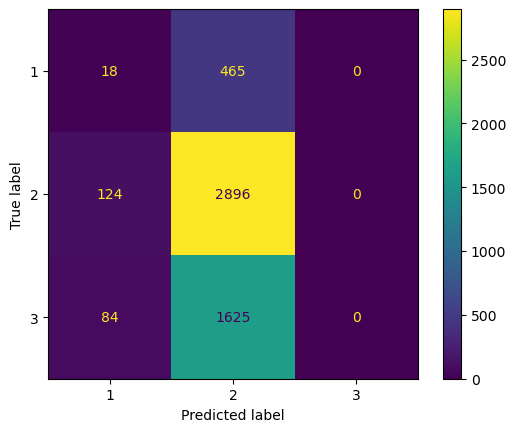

In [12]:
ConfusionMatrix(y_pred, [1, 2, 3])

### Modelo SVC con Cross Validation y Grid Search

In [15]:
%%time

param_grid = {'svc__C': [0.1, 1, 10], 'svc__gamma': [0.1, 1, 10]}

grid_search = ApplyGridSearch(make_pipeline(StandardScaler(), SVC()), param_grid)

# Acceder al modelo entrenado con los hiperparámetros óptimos
SVC_model_grid_search = grid_search.best_estimator_

y_pred = SVC_model_grid_search.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred)

print('---------------------------------')
print(f'Precisión del modelo: {accuracy}')

Puntajes de validación cruzada anidada: [0.66464194 0.66805245 0.66901183 0.65142309 0.64438759]
Puntaje promedio: 0.6595033807519197
---------------------------------
Precisión del modelo: 0.6605909439754413
CPU times: total: 41min 33s
Wall time: 41min 56s


              precision    recall  f1-score   support

           1       0.08      0.05      0.06       483
           2       0.58      0.67      0.62      3020
           3       0.33      0.28      0.30      1709

    accuracy                           0.48      5212
   macro avg       0.33      0.33      0.33      5212
weighted avg       0.45      0.48      0.46      5212



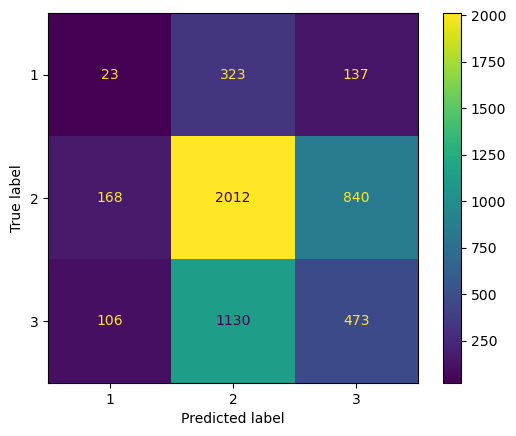

In [14]:
ConfusionMatrix(y_pred, [1 ,2, 3])

### Modelo SVC con Cross Validation y Random Search

In [16]:
param_dist = {
	'svc__C': [0.1, 1, 10, 100],  # Parámetro de regularización para SVC
	'svc__gamma': [0.1, 0.01, 0.001, 0.0001],  # Coeficiente del kernel para 'rbf', 'poly' y 'sigmoid
	'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Tipo de kernel a utilizar para SVC
	'svc__degree': [2, 3, 4, 5]  # Grado del polinomio para el kernel 'poly' para SVC
}

random_search = ApplyRandomSearch(make_pipeline(StandardScaler(), SVC()), param_dist)

# Acceder al modelo entrenado con los hiperparámetros óptimos
SVC_model_random_search = random_search.best_estimator_

y_pred = SVC_model_random_search.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred)

print('---------------------------------')
print(f'Precisión del modelo: {accuracy}')
print(f'Reporte de clasificación:\n{report}')

### Lazy Predict

In [15]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

print(models)

100%|██████████| 29/29 [00:29<00:00,  1.02s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000301 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 46
[LightGBM] [Info] Number of data points in the train set: 15636, number of used features: 5
[LightGBM] [Info] Start training from score -2.346113
[LightGBM] [Info] Start training from score -0.569950
[LightGBM] [Info] Start training from score -1.082624
                               Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                                                                          
ExtraTreeClassifier                0.66               0.55    None      0.65   
ExtraTreesClassifier               0.66               0.55    None      0.65   
DecisionTreeClassifier             0.66               0.55    None      0.65   
RandomForestClassifier             0.66               0.54    None      0.65   
BaggingC

### LGBMClassifier

In [12]:
%%time

classifier = lgb.LGBMClassifier()
LGBM_model = classifier.fit(X_train, y_train)

y_pred = LGBM_model.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred)

print(f'Precisión del modelo: {accuracy}')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000801 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 41
[LightGBM] [Info] Number of data points in the train set: 15636, number of used features: 5
[LightGBM] [Info] Start training from score -2.346113
[LightGBM] [Info] Start training from score -0.569950
[LightGBM] [Info] Start training from score -1.082624
Precisión del modelo: 0.6628933231005372
CPU times: total: 2.38 s
Wall time: 1.07 s


              precision    recall  f1-score   support

           1       0.08      0.05      0.06       483
           2       0.58      0.66      0.62      3020
           3       0.32      0.28      0.30      1709

    accuracy                           0.48      5212
   macro avg       0.33      0.33      0.33      5212
weighted avg       0.45      0.48      0.46      5212



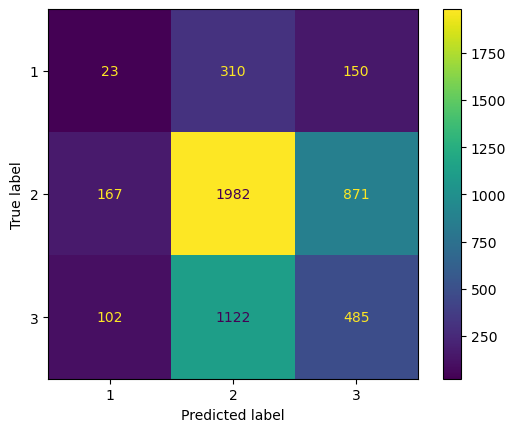

In [17]:
ConfusionMatrix(y_pred, [1, 2, 3])

In [22]:
y_pred.shape

(5212,)

In [19]:
joblib.dump(SVC_model_grid_search, 'SVC_model_grid_search.pkl')

['SVC_model_grid_search.pkl']

In [20]:
joblib.dump(LGBM_model, 'LGBM_model.pkl')

['LGBM_model.pkl']

In [23]:
param_grid = {'svc__C': [0.1, 1, 10], 'svc__gamma': [0.1, 1, 10]}

grid_search = ApplyGridSearch(make_pipeline(StandardScaler(), SVC()), param_grid)

# Acceder al modelo entrenado con los hiperparámetros óptimos
SVC_model_grid_search = grid_search.best_estimator_

y_pred = SVC_model_grid_search.predict(test_values)

accuracy = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred)

print('---------------------------------')
print(f'Precisión del modelo: {accuracy}')

KeyboardInterrupt: 

In [30]:
earthquake_categ_cols = [
  'land_surface_condition', 
  'foundation_type',
  'roof_type',
  'ground_floor_type',
  'other_floor_type',
  'position',
  'plan_configuration',
  'legal_ownership_status'
]

test_transformed = TransformVars(test_values, categ_cols = earthquake_categ_cols)
test_transformed = test_transformed[['has_superstructure_mud_mortar_stone', 'has_superstructure_rc_engineered', 'has_superstructure_mud_mortar_brick', 'geo_level_1_id', 'other_floor_type']]

y_pred = LGBM_model.predict(test_transformed)

accuracy = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred)

print(f'Precisión del modelo: {accuracy}')

ValueError: Found input variables with inconsistent numbers of samples: [5212, 86868]

In [31]:
print(X_train.shape)
print(test_transformed.shape)

(15636, 5)
(86868, 5)
